In [1]:
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
from ase import io
from ase.visualize import view
from ase.build import sort, molecule
from ase.optimize import QuasiNewton, FIRE

In [180]:
# from helpers import validate
# from helpers import read_metrics

In [5]:
from pyace import PyACECalculator

In [6]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
# mpl.rcParams['font.family'] = 'Times'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.top']=True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right']=True

In [7]:
calc = PyACECalculator('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.yaml',
    keep_extrapolative_structures=True,
    gamma_lower_bound=1.2,
    gamma_upper_bound=10,
    stop_at_large_extrapolation=False)
calc.set_active_set('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.asi')

In [8]:
def linear_fn(x, a, b):
    return a*x + b

In [249]:
import os
import warnings
def read_log(path):
    os.system(f'cat {path}/lmp.out | grep -e Step -e Loop -n > read_log')
    file = open('read_log').readlines()
#     os.system('rm read_log')
    log_lst = list()
    for i in range(0,len(file),2):
        try:
                n1 = int(file[i].replace(':',' ').split()[0])
                n2 = int(file[i+1].replace(':',' ').split()[0])
                log_lst.append(pd.read_csv(f'{path}/lmp.out',
                                   skiprows=n1-1, nrows=n2-n1-1, sep= '\s+'))
        except:
            break

    if(len(file)%2 ==0):
        return log_lst
    else:
        warnings.warn('Last run is not finished')            
        n = int(file[-1].replace(':',' ').split()[0])
        log_lst.append(pd.read_csv(f'{path}/lmp.out', skiprows=n-1, sep= '\s+'))

    return log_lst

In [221]:
def write_lmp_file_eq(T, P, path, pot_dir):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
 f'variable        seed equal {s}\n',
 '\n',
 f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
 f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
  f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',           
 '\n',
 'fix             3 all nph aniso ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run 20000 \n',
 '\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 'dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 'dump_modify     3 element H O\n',            
 '\n',
 'fix             3 all nph aniso ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run             2000000\n',
 '\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',]
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_lmp_file(T, P, path, pot_dir):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
 f'variable        seed equal {s}\n',
 '\n',
 f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
 f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
 f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
 'fix             1 all plumed plumedfile plumed.equil.dat outfile plumed.out\n',
 'fix             3 all nph z ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run 200000 \n',
 '\n',
 'unfix 1\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 '#dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 '#dump_modify     3 element H O\n',
 '\n',
 '\n',
 'fix             1 all plumed plumedfile plumed.start.dat outfile plumed.out\n',
 'fix             3 all nph z ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run             20000000\n',
 '\n',
 'unfix\t\t1\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',]
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_strict(sigma, intersect, path):
    lines=['\n',
     '# Strict counting of molecules\n',
     'ENVIRONMENTSIMILARITY ...\n',
     ' SPECIES=1441-2160:1\n',
     f' SIGMA={sigma}\n',
     ' CRYSTAL_STRUCTURE=BCC\n',
     ' LATTICE_CONSTANTS=0.34072718272556335\n'
     ' LABEL=refcv2\n',
     ' MORE_THAN={CUBIC '+ f'D_0={intersect} D_MAX={intersect}0001'+'}\n',
     ' MEAN\n',
     '... ENVIRONMENTSIMILARITY\n']
    fr = open(f'{path}/plumed.strict.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_smooth(sigma, x_ice, x_liq, path):
    lines = ['ENVIRONMENTSIMILARITY ...\n',
     ' SPECIES=1441-2160:1\n',
     f' SIGMA={sigma}\n',
     ' CRYSTAL_STRUCTURE=BCC\n',
     ' LATTICE_CONSTANTS=0.34072718272556335\n'
     ' LABEL=refcv\n',
     ' MORE_THAN={'+f'CUBIC D_0={x_ice} D_MAX={x_liq}'+'}\n',
     ' MEAN\n',
     '... ENVIRONMENTSIMILARITY\n']
    fr = open(f'{path}/plumed.smooth.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return
    

def write_plumed_eq_file(cv_min, cv_max, path):
    lines= ['# vim:ft=plumed\n',
 '\n',
 '\n',
 'INCLUDE FILE=plumed.smooth.dat\n',
 '\n',
 f'uwall: UPPER_WALLS ARG=refcv.morethan AT={cv_max} KAPPA=1.0 EXP=2 STRIDE=2\n',
 f'lwall: LOWER_WALLS ARG=refcv.morethan AT={cv_min} KAPPA=1.0 EXP=2 STRIDE=2\n',
 '\n',
 'INCLUDE FILE=plumed.strict.dat\n',
 '\n',
 '\n',
 'PRINT STRIDE=500  ARG=* FILE=COLVAR-EQUIL\n']
    fr = open(f'{path}/plumed.equil.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_file(T, cv_min, cv_max, path):
    lines= ['# vim:ft=plumed\n',
 '\n',
 '\n',
 'INCLUDE FILE=plumed.smooth.dat\n',
 '\n',
 f'umb1: ECV_UMBRELLAS_LINE ARG=refcv.morethan TEMP={T} CV_MIN={cv_min} CV_MAX={cv_max} SIGMA=1 BARRIER=50\n',
 'opes: OPES_EXPANDED ARG=umb1.* PACE=500 STRIDE=2 WALKERS_MPI\n',      
 '\n',
 f'uwall: UPPER_WALLS ARG=refcv.morethan AT={cv_max+5} KAPPA=1.0 EXP=2 STRIDE=2\n',
 f'lwall: LOWER_WALLS ARG=refcv.morethan AT={cv_min-5} KAPPA=1.0 EXP=2 STRIDE=2\n',
 '\n',
 'INCLUDE FILE=plumed.strict.dat\n',
 '\n',
 '\n',
 'PRINT STRIDE=500  ARG=* FILE=COLVAR\n']
    fr = open(f'{path}/plumed.start.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_mrn(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --account=cicn2\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=4\n'
    '#SBATCH --cpus-per-task=20\n'
    '#SBATCH --time=3-00:00:00\n'
    '#SBATCH --gres=gpu:4\n'
    '#SBATCH --qos=acc_resa\n'
    '\n'
    '\n'
    'module purge\n'
    'ml load mkl intel cuda/12.2 openmpi/4.1.5-gcc fftw/3.3.10-gcc-ompi gsl/2.8-gcc lammps/7Feb2024\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp_mpi -k on g 4  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_hyp(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=1\n'
    '#SBATCH --cpus-per-task=20\n'
    '#SBATCH --time=8-00:00:00\n'
    '#SBATCH --gres=gpu:1\n'
    '#SBATCH --constraint=gpu-icelake|gpu-cascadelake\n'
    '#SBATCH --partition=general\n'
    '#SBATCH --qos=xlong\n'
    '\n'
    '\n'
    'module purge\n'
    'ml load LAMMPS/27Jun2024-foss-2021b-kokkos-PLUMED-2.8.0-CUDA-11.4.1\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp -k on g 1 -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_zgh(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --time=7-23:59:00\n'
    '#SBATCH --partition=compute\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=28\n'
    '#SBATCH --cpus-per-task=2\n'
    '\n'
    '\n'
    'module purge\n'
    'module load lammps/latest-gnu-z\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'mpirun -np 28 lmp_mpi  -in in.lammps  > lmp.out'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    
def write_sbatch_pc2(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=1\n'
    '#SBATCH --cpus-per-task=128\n'
    '#SBATCH --time=2-00:00:00\n'
    '#SBATCH --gres=gpu:a100:1\n'
    '#SBATCH --partition=gpu\n'
    '#SBATCH --mem=40GB\n'
    '\n'
    '\n'
    'module purge\n'
    'module load chem/LAMMPS/27Jun2024-foss-2023b-kokkos-CUDA-12.5.0\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp -k on g 1 -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

In [243]:
def plot_stats_eq(path, skip=0):
    #Read the data from the path
    
    data = pd.read_csv(f'{path}/COLVAR-EQUIL',sep= '\s+')
    data.columns = np.roll(data.columns,-2)

    log = read_log(f'{path}/')[1]
        
    fig, ax = plt.subplots(figsize=(16,4), ncols=4)
    
    ax[0].plot(data['time'][skip:]*1E-3, data['refcv.morethan'][skip:], alpha=1., c='k')
    ax[0].axhline(np.average(data['refcv.morethan'][skip:]), ls='--', color='w', lw=2)
    ax[0].set_xlabel('Time [ns]')
    ax[0].set_title('$\mathrm{n_{ice,strict}}$')
    
    ax[1].plot(data['time'][skip:]*1E-3, data['refcv2.morethan'][skip:], alpha=1., c='k')
    ax[1].axhline(np.average(data['refcv2.morethan'][skip:]), ls='--', color='w', lw=2)
    ax[1].set_xlabel('Time [ns]')
    ax[1].set_title('$\mathrm{n_{ice,smooth}}$')

    ax[2].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=1., c='k')
    ax[2].axhline(log.Temp[skip:].mean(), ls='--', color='w', lw=2)
    ax[2].set_xlabel('Time [ns]')
    ax[2].set_title('T [K]')

    ax[3].plot(log.Step[skip:]*5e-7,log.Press[skip:]*1e-4, alpha=1., c='k')
    ax[3].axhline(log.Press[skip:].mean()*1e-4, ls='--', color='w', lw=2)
    ax[3].set_xlabel('Time [ns]')
    ax[3].set_title('P [GPa]')
    
def plot_stats(path, skip=0):
    #Read the data from the path
    
    data = np.loadtxt(f'{path}/COLVAR')
    log = read_log(f'{path}/')[-1][:-2]
        
    fig, ax = plt.subplots(figsize=(16,4), ncols=4)
    
    ax[0].plot(data[skip:,0]*1E-3, data[skip:,-1], c='k')
    ax[0].axhline(np.average(data[skip:,-1]), ls='--', color='w', lw=2)
    ax[0].set_xlabel('Time [ns]')
    ax[0].set_title('$\mathrm{n_{ice,strict}}$')
    
    ax[1].plot(data[skip:,0]*1E-3, data[skip:,2], c='k')
    ax[1].axhline(np.average(data[skip:,2]), ls='--', color='w', lw=2)
    ax[1].set_xlabel('Time [ns]')
    ax[1].set_title('$\mathrm{n_{ice,smooth}}$')

    ax[2].scatter(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=.1, c='k')
    ax[2].axhline(log.Temp[skip:].mean(), ls='--', color='w', lw=2)
    ax[2].set_xlabel('Time [ns]')
    ax[2].set_title('T [K]')

    ax[3].scatter(log.Step[skip:]*5e-7,log.Press[skip:]*1e-4, alpha=.1, c='k')
    ax[3].axhline(log.Press[skip:].mean()*1e-4, ls='--', color='w', lw=2)
    ax[3].set_xlabel('Time [ns]')
    ax[3].set_title('P [GPa]')

In [67]:
df = pd.read_pickle('/home/users/saadie5f/our_dft/DATASETS/data_relax.gzip', compression='gzip')
df

,energy,forces,ase_atoms,energy_corrected,energy_corrected_per_atom
ice7,-236.08285,"[[0.00232998, -0.00152794, 0.00303619], [0.000...","(Atom('H', [0.5170338272351557, 5.972355192734...",-231.694652,-4.826972
8,-944.922854,"[[6.24e-06, 0.00074742, 0.00011087], [-1.108e-...","(Atom('H', [-8.701062305200001e-06, 0.36020687...",-927.370063,-4.830052
VIII,-944.922854,"[[6.41e-06, 0.00074926, 0.00010935], [-1.094e-...","(Atom('H', [-8.8271455714e-06, 0.3602067232120...",-927.370063,-4.830052
ice8,-944.922854,"[[6.32e-06, 0.00074963, 0.00010919], [-1.109e-...","(Atom('H', [-8.8191570082e-06, 0.3602068855267...",-927.370063,-4.830052
9,-177.376658,"[[-0.00042732, 0.00052582, 0.00066274], [5.103...","(Atom('H', [5.55775650936389, 1.36554758032590...",-174.08551,-4.835709
...,...,...,...,...,...
engel31,-944.837959,"[[-0.00182886, 0.0007797, 0.00050987], [0.0022...","(Atom('H', [3.57117640984236, 8.30252944596885...",-927.285168,-4.82961
sVII,-177.082697,"[[0.00353119, 0.00050999, 0.00032742], [0.0031...","(Atom('H', [0.7736366979766524, 6.298655111701...",-173.791549,-4.827543
11i,-236.76352,"[[8.14e-06, 0.00220267, 0.00184673], [3.054e-0...","(Atom('H', [1.31117743649e-05, 3.5353644151761...",-232.375322,-4.841153
12,-354.109427,"[[0.00049145, -0.00130716, -0.00126622], [-0.0...","(Atom('H', [5.234866560163703, 0.6336570264142...",-347.527131,-4.826766


In [68]:
i_atoms = df[df.index == 'ice7'].ase_atoms.values[0]

In [71]:
len(i_atoms)/3

16.0

In [69]:
view(i_atoms, viewer='nglview')

In [72]:
bulk_atoms = i_atoms.repeat(3)
# bulk_atoms.set_calculator(calc)
# opt = QuasiNewton(bulk_atoms)
# opt.run(fmax=0.05)

In [74]:
len(bulk_atoms)/3

432.0

In [227]:
pot_dir = '/pc2/users/a/acepdw01/work/phase_diagram/pot_dir'

p = 30000
# os.mkdir(f'../../full/vii/{p}_bar/')
os.mkdir(f'../../full/vii/{p}_bar/1-bulk')

for T in np.arange(485,506,5, dtype=int):
    path = f'../../full/vii/{p}_bar/1-bulk/{T}/'
    os.mkdir(path)
    write_lmp_file_eq(T,p, path, pot_dir)
    io.write(path+'water.dat', sort(bulk_atoms), format='lammps-data', specorder=['H', 'O'])

    write_sbatch_pc2(path)

In [636]:
traj = io.read('../vii/30000_bar/1-bulk/505/traj.lammpstrj', index=':')
view(traj, viewer='nglview')

In [686]:
melt_traj = io.read('../vii/28000_bar/1-bulk/melt/traj.lammpstrj', index=':')
for atoms in tqdm(melt_traj):
    atoms.wrap()
view(melt_traj, viewer='nglview')

100%|██████████| 2000/2000 [00:01<00:00, 1978.27it/s]


In [694]:
melt_atoms = melt_traj[0]
view(melt_atoms, viewer='nglview')

In [705]:
interface = bulk_atoms+melt_atoms
interface.positions[len(bulk_atoms):] = melt_atoms.positions
interface.positions[len(bulk_atoms):] += [0,0,bulk_atoms.cell[2,2]]
interface.cell[2,2] = bulk_atoms.cell[2,2]*2
interface.wrap()
view(interface, viewer='nglview')

(0.4, 1.5)

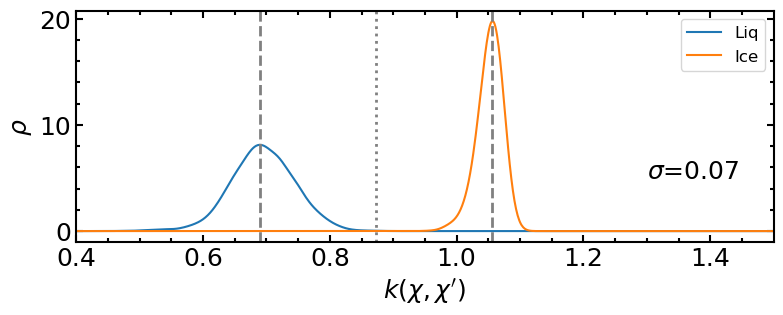

In [294]:
sigma = 0.07
s = f'histo-{sigma:.2f}'
data_ice=np.loadtxt("../vii/dist_on_the_fly/ice/histo")
data_liq=np.loadtxt("../vii/dist_on_the_fly/liquid/histo")

x_liq = data_liq[:,0][np.argmax(data_liq[:,1])]
x_ice = data_ice[:,0][np.argmax(data_ice[:,1])]
intersect = np.round((x_liq+x_ice)/2,4)

fig, axs= plt.subplots(figsize=(9,3), nrows=1,sharex=True) #,sharey=True)
axs.plot(data_liq[:,0],data_liq[:,1], label='Liq')
axs.plot(data_ice[:,0],data_ice[:,1], label='Ice')
axs.text(1.3,np.amax(data_ice[:,1])/4,r"$\sigma$=" + f'{sigma:.2f}', fontsize=18)

axs.axvline(x_liq, ls='--', lw=2, color='gray')
axs.axvline(x_ice, ls='--', lw=2, color='gray')
axs.axvline(intersect, ls=':', lw=2, color='gray')

    
axs.legend(fontsize=12, loc='upper right')
axs.set_ylabel(r"$\rho$")
axs.set_xlabel(r"$k(\chi,\chi')$")

axs.set_xlim(0.4,1.5)

In [293]:
x_liq, x_ice, intersect

(0.69, 1.05625, 0.8731)

In [99]:
init_atoms = io.read('../vii/30000_bar/2-coex/460/water.dat', format='lammps-data', style='atomic')
init_atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, init_atoms.get_chemical_symbols())))
view(init_atoms, viewer='nglview')

In [133]:
traj = io.read('../vii/dist_on_the_fly/test/traj.lammpstrj', index=':')
# for atoms in tqdm(traj):
#     atoms.wrap()
view(traj, viewer='nglview')

In [716]:
traj = io.read('../vii/interface3/traj.lammpstrj', index=':')
for atoms in tqdm(traj):
    atoms.wrap()
view(traj, viewer='nglview')

100%|██████████| 42/42 [00:00<00:00, 1268.47it/s]


In [82]:
view(traj[-1], viewer='nglview')

In [736]:
traj = io.read('../vii/30000_bar/test/traj.lammpstrj', index=':')
for atoms in tqdm(traj):
    atoms.wrap()
view(traj, viewer='nglview')

100%|██████████| 20/20 [00:00<00:00, 981.01it/s]


In [84]:
interface_atoms = sort(traj[-1])
cv_min = (len(interface_atoms)/3/10) * 5
cv_max = (len(interface_atoms)/3/10) * 6
cv_min, cv_max

(360.0, 432.0)

In [157]:
interface_atoms.set_calculator(calc)
opt = QuasiNewton(interface_atoms)
opt.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 00:34:28   -10283.056769*       6.0423
BFGSLineSearch:    1[  2] 00:34:33   -10315.029907*       2.6486
Upper extrapolation threshold exceed: max(gamma) = 16.511004241301205
BFGSLineSearch:    2[  4] 00:34:41   -10326.769672*       2.7786
BFGSLineSearch:    3[  6] 00:34:49   -10344.145287*       4.0703
BFGSLineSearch:    4[  8] 00:34:57   -10350.018993*       1.9794
BFGSLineSearch:    5[  9] 00:35:03   -10364.624798*       5.7424
BFGSLineSearch:    6[ 11] 00:35:10   -10371.241440*       1.9711
BFGSLineSearch:    7[ 13] 00:35:18   -10373.616826*       1.7260
BFGSLineSearch:    8[ 14] 00:35:24   -10378.312058*       9.3470
BFGSLineSearch:    9[ 16] 00:35:32   -10381.456895*       3.1612
BFGSLineSearch:   10[ 18] 00:35:40   -10383.085079*       4.8875
BFGSLineSearch:   11[ 20] 00:35:48   -10386.503778*       1.6309
BFGSLineSearch:   12[ 22] 00:35:56  

True

In [183]:
o_indices = np.where(np.array(interface_atoms.get_chemical_symbols())=='O')[0]+1
min(o_indices), max(o_indices)

(1441, 2160)

In [726]:
p = 30000

path = f'../../full/vii/{p}_bar'
io.write(f'{path}/test/water.dat', traj[-1], format='lammps-data', specorder=['H', 'O'])

In [742]:
p = 30000

path = f'../../full/vii/{p}_bar'
pot_dir = '/pc2/users/a/acepdw01/work/phase_diagram/pot_dir'
# os.mkdir(f'{path}/melting_test')
for T in np.arange(450,471,5, dtype=int):
    os.mkdir(f'{path}/1-bulk/{T}')
        
    io.write(f'{path}/1-bulk/{T}/water.dat', bulk_atoms, format='lammps-data', specorder=['H', 'O'])
    
    write_lmp_file_eq(T,p,f'{path}/1-bulk/{T}/', pot_dir)
        
    write_sbatch_pc2(f'{path}/1-bulk/{T}/', f'pd-T={T}')

In [222]:
p = 30000

path = f'../../full/vii/{p}_bar'
pot_dir = '/pc2/users/a/acepdw01/work/phase_diagram/pot_dir'
# os.mkdir(f'{path}/2-coex')

for T in np.arange(450,471,5, dtype=int):
    os.mkdir(f'{path}/2-coex/{T}')
    
    traj = io.read(f'{path}/1-bulk/{T}/traj.lammpstrj', index=':')
    
    x = np.average(list(map(lambda at: at.cell[0,0], traj)))    
    y = np.average(list(map(lambda at: at.cell[1,1], traj)))
    
    interface_atoms.cell[0,0] = x
    interface_atoms.cell[1,1] = y
    
    io.write(f'{path}/2-coex/{T}/water.dat', interface_atoms, format='lammps-data', specorder=['H', 'O'])
    
    write_lmp_file(T,p,f'{path}/2-coex/{T}/', pot_dir)
    
    write_plumed_smooth(sigma, x_liq, x_ice, f'{path}/2-coex/{T}/')
    write_plumed_strict(sigma, intersect, f'{path}/2-coex/{T}/')
    write_plumed_eq_file(cv_min, cv_max, f'{path}/2-coex/{T}/')
    write_plumed_file(T, cv_min, cv_max, f'{path}/2-coex/{T}/')
    
    write_sbatch_pc2(f'{path}/2-coex/{T}/', f'pd-T={T}')

In [285]:
# traj = io.read('../vii/30000_bar/2-coex/465/traj.lammpstrj', index=':')
# view(traj, viewer='nglview')

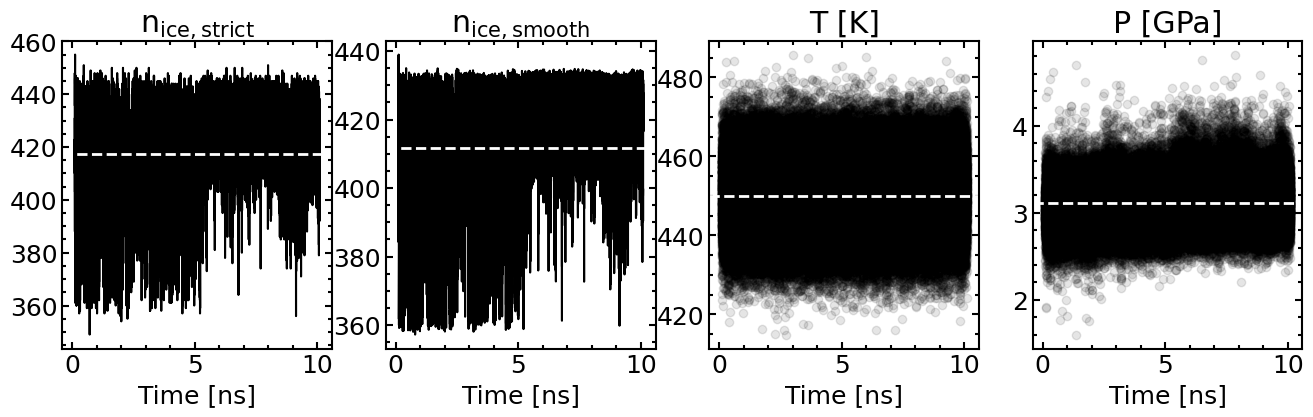

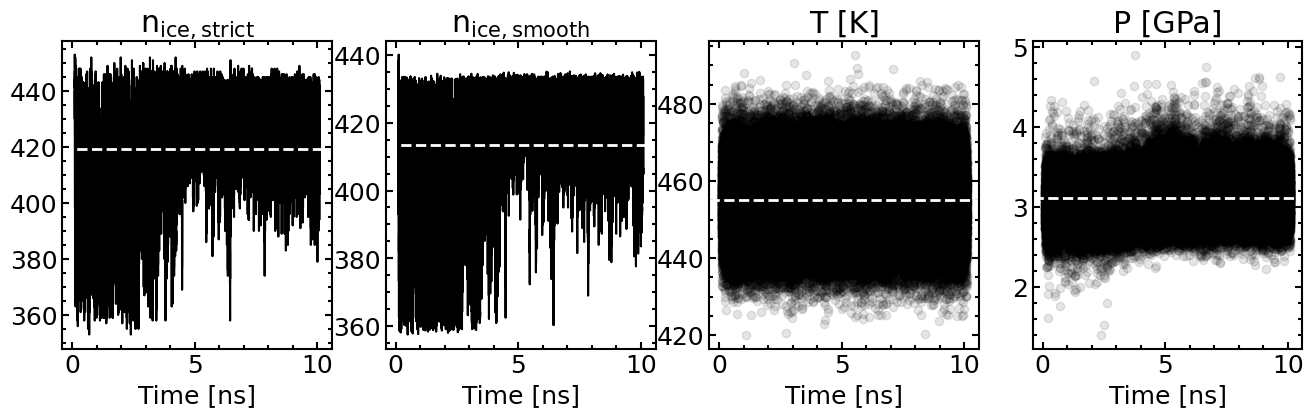

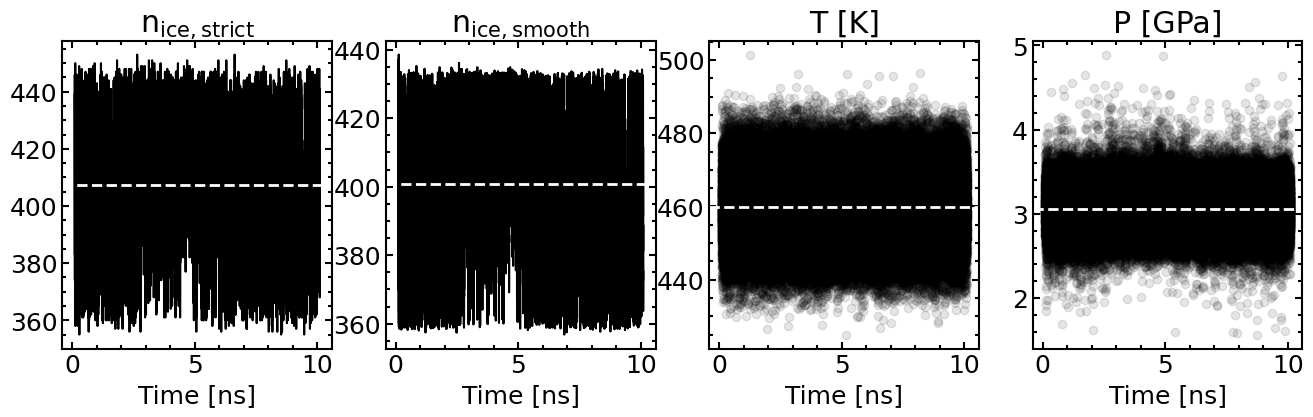

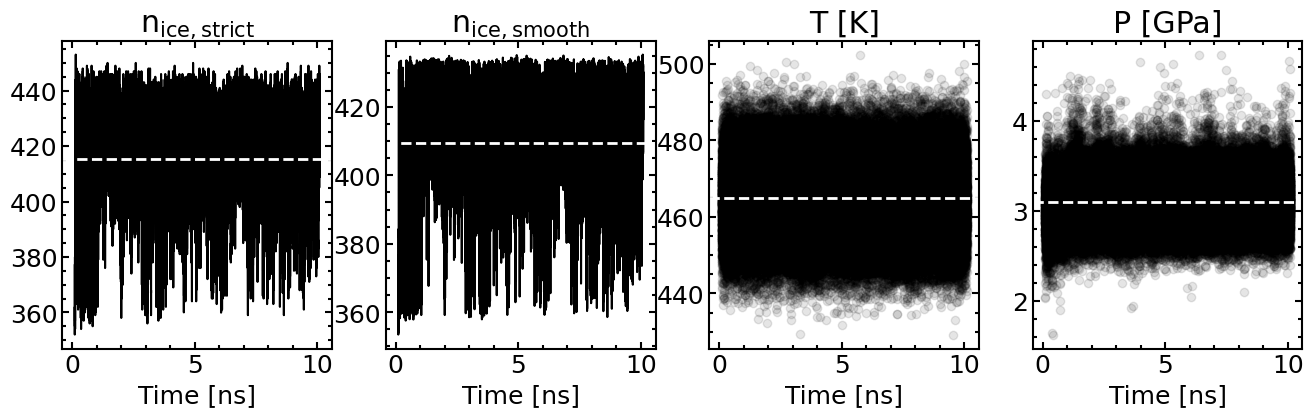

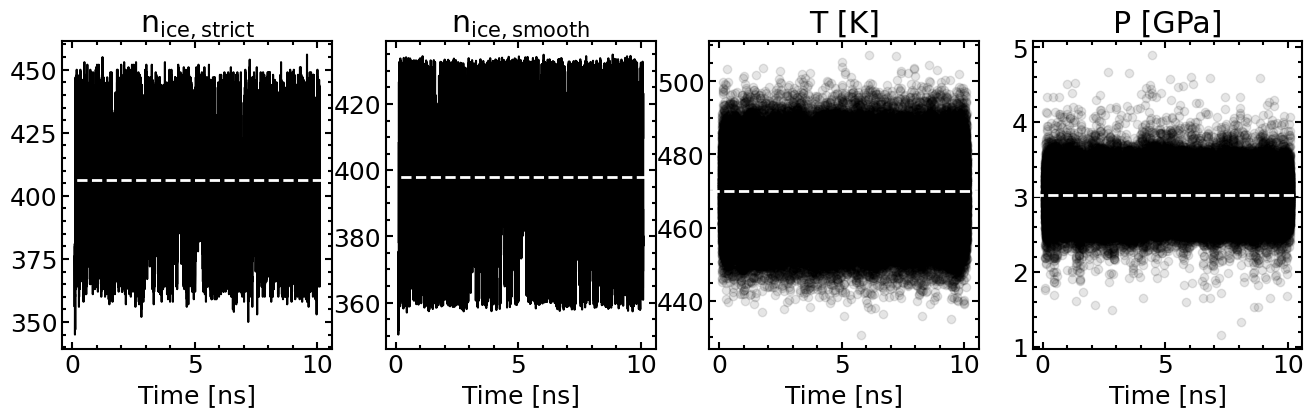

In [268]:
for T in np.arange(450,471,5, dtype=int):
    plot_stats(f'../../full/vii/30000_bar/2-coex/{T}', skip=10)

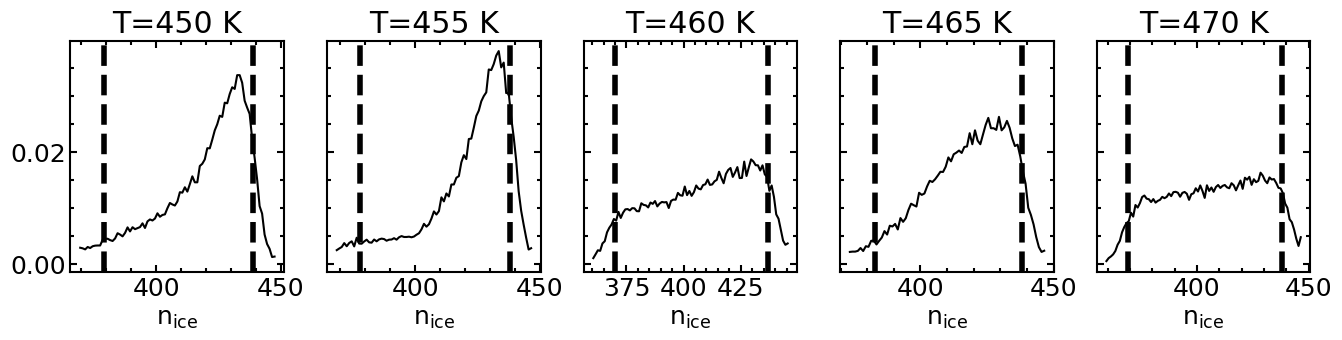

In [273]:
fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

for i, T in enumerate(np.arange(450,471,5, dtype=int)):
    path = f'../../full/vii/30000_bar/2-coex/{T}'
    data = pd.read_csv(f'{path}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=1     # Bin size used for histogram
    ig=2000 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data['time'][ig:]/1E3
    number_of_ice  = data['refcv2.morethan'][ig:]

    histo, bin_edges = np.histogram(number_of_ice,bins=100)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-10,nf+10)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    ax[i].plot(n_ice_mid,histo, c='k')
    ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    ax[i].set_title(f'T={T} K')
    ax[i].set_xlabel('$\mathrm{n_{ice}}$')

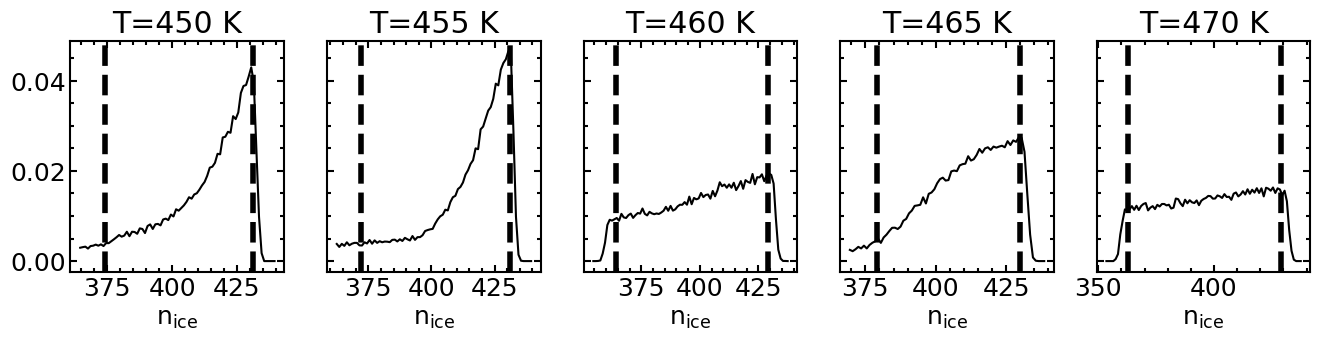

In [274]:
fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

for i, T in enumerate(np.arange(450,471,5, dtype=int)):
    path = f'../../full/vii/30000_bar/2-coex/{T}'
    data = pd.read_csv(f'{path}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=1     # Bin size used for histogram
    ig=2000 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data['time'][ig:]/1E3
    number_of_ice  = data['refcv.morethan'][ig:]

    histo, bin_edges = np.histogram(number_of_ice,bins=100)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-10,nf+10)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    ax[i].plot(n_ice_mid,histo, c='k')
    ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    ax[i].set_title(f'T={T} K')
    ax[i].set_xlabel('$\mathrm{n_{ice}}$')

Text(0, 0.5, '$\\Delta$G$_{\\mathrm{liq}\\to \\mathrm{ice}}$ (kJ mol$^{-1}$)')

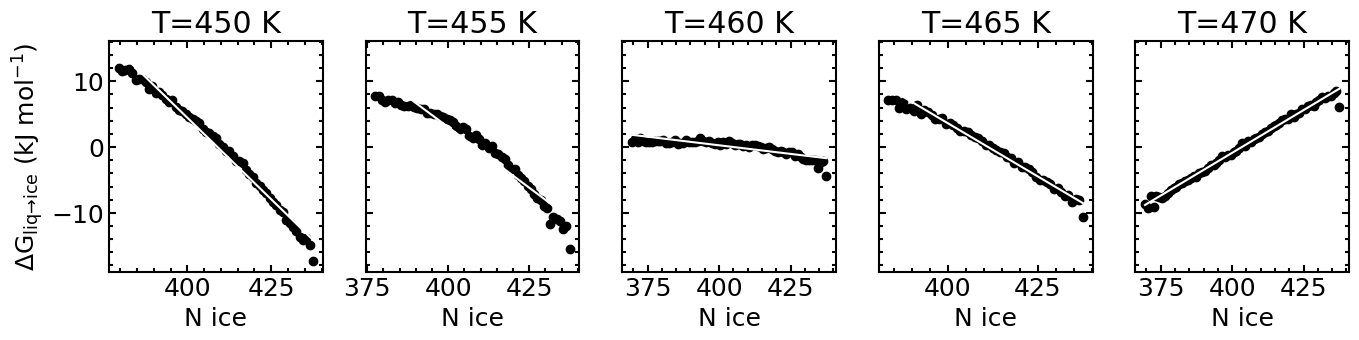

In [281]:
from scipy.optimize import curve_fit

def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

colors = plt.cm.viridis(np.linspace(0,1,5))
colors = ['k']*5
for i, T in enumerate(np.arange(450,471,5, dtype=int)):
    path = f'../../full/vii/30000_bar/2-coex/{T}'
    data = pd.read_csv(f'{path}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)
    
    ign = 2000
    
    number_of_ice  = data['refcv2.morethan'][ign:]
    bias_potential = data['opes.bias'][ign:]+data['lwall.bias'][ign:]+data['uwall.bias'][ign:]

    histo, bin_edges = np.histogram(number_of_ice,bins=300)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax( logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)
    fes_error = (1/beta)*histo_error/histo
    bin_centers = bin_centers
    

#     fes_error = (1/beta)*histo_error/histo
#     args = np.isfinite(fes) & np.isfinite(fes_error) & (fes_error != 0)
#     fes = fes[args]
#     fes_error = fes_error[args]
#     bin_centers = bin_centers[args]
    
    
    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=100)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]

    ax[i].scatter(n_water,fes, c=colors[i])
    ax[i].plot(n_water,fes_linear, c='w')
    ax[i].set_title(f'T={T} K')   
    ax[i].set_xlabel('N ice')
ax[0].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')

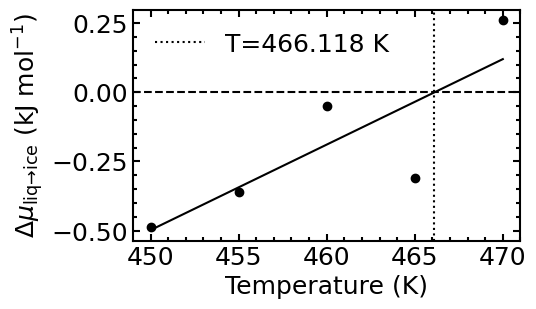

In [282]:
chem_pot_lst = np.zeros((5,3))

for i, T in enumerate(np.arange(450,471,5, dtype=int)):
    path = f'../../full/vii/30000_bar/2-coex/{T}'
    data = pd.read_csv(f'{path}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)
    
    ign = 1000
    
    number_of_ice  = data['refcv2.morethan'][ign:]
    bias_potential = data['opes.bias'][ign:]+data['lwall.bias'][ign:]+data['uwall.bias'][ign:]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

#     args = np.isfinite(fes) & np.isfinite(fes_error) & (fes_error != 0)
#     fes = fes[args]
#     fes_error = fes_error[args]
#     bin_centers = bin_centers[args]
#     args = np.argsort(fes_error)

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=100)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]
    chem_pot_lst[i,0] = T
    chem_pot_lst[i,1] = popt[0]
    chem_pot_lst[i,2] = perr
    
    popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=100)


plt.figure(figsize=(5,3))
plt.scatter(chem_pot_lst[:,0],chem_pot_lst[:,1], c='k')
plt.plot(chem_pot_lst[:,0],linear_fn(chem_pot_lst[:,0],*popt), c='k')
plt.axhline(0, ls='--', c='k')
plt.axvline(-popt[1]/popt[0], ls=':', label=f'T={np.round(-popt[1]/popt[0],3)} K', c='k')
plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
plt.xlabel('Temperature (K)')    
plt.legend(frameon=False)

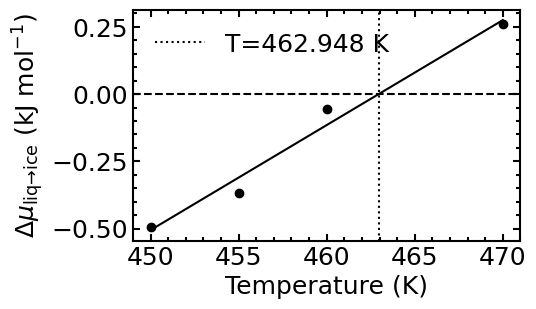

In [283]:
chem_pot_lst = np.zeros((4,3))

for i, T in enumerate([450,455,460,470]):
    path = f'../../full/vii/30000_bar/2-coex/{T}'
    data = pd.read_csv(f'{path}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)
    
    ign = 2000
    
    number_of_ice  = data['refcv2.morethan'][ign:]
    bias_potential = data['opes.bias'][ign:]+data['lwall.bias'][ign:]+data['uwall.bias'][ign:]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

#     args = np.isfinite(fes) & np.isfinite(fes_error) & (fes_error != 0)
#     fes = fes[args]
#     fes_error = fes_error[args]
#     bin_centers = bin_centers[args]
#     args = np.argsort(fes_error)

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=100)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]
    chem_pot_lst[i,0] = T
    chem_pot_lst[i,1] = popt[0]
    chem_pot_lst[i,2] = perr
    
    popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=100)


plt.figure(figsize=(5,3))
plt.scatter(chem_pot_lst[:,0],chem_pot_lst[:,1], c='k')
plt.plot(chem_pot_lst[:,0],linear_fn(chem_pot_lst[:,0],*popt), c='k')
plt.axhline(0, ls='--', c='k')
plt.axvline(-popt[1]/popt[0], ls=':', label=f'T={np.round(-popt[1]/popt[0],3)} K', c='k')
plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
plt.xlabel('Temperature (K)')    
plt.legend(frameon=False)